In [3]:
# import libraries
!pip install pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession,Window
from pyspark.sql.types import *
from pyspark.sql.functions import *

import re
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


     |████████████████████████████████| 281.4 MB 35 kB/s 
     |████████████████████████████████| 198 kB 58.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=e988f98604fb900b91c5b70f646e087d01fc904a1c596b536ee047e3909d8277
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [4]:
# Create spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()


# Data Preprocessing

In [17]:

df = spark.read.json('s3n://udacity-dsnd/sparkify/sparkify_event_data.json')
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [10]:
# check the columns
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [11]:
# count rows
# print('There are',df.count(),'observations in this dataset.')
print('There are',df.count(),'observations in this dataset.')

# show first 5 rows
df.show(n=5)

There are 286500 observations in this dataset.
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bosto

In [12]:
### Get count of both null and missing values in pyspark
from pyspark.sql.functions import isnan, when, count, col 
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [18]:
# Deleting the rows with missing value in firstName column
df_clean = df.filter(df.userId != "")
df_clean.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_clean.columns]).show()


+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [ ]:
# Deleting the rows with missing value in artist column
#df_clean = df_clean.filter(df.artist != "")
#df_clean.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_clean.columns]).show()

# Notice: In small dataset, we can not delete the artist column with missing value or it will delete all the cancel confirmation roll
# But in the large dataset, it's ok to delete the artist column with missing value

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [19]:
# Extract the state abbreviation from the original address in location column
df_clean = df_clean.withColumn('state', trim(split(col('location'),',').getItem(1)))

# drop unnecessary column
df_clean = df_clean.drop('location','firstName','lastName')
df_clean.show(n = 5)

+----------------+---------+------+-------------+---------+-----+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|          artist|     auth|gender|itemInSession|   length|level|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|state|
+----------------+---------+------+-------------+---------+-----+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|  Martha Tilston|Logged In|     M|           50|277.89016| paid|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|   CA|
|Five Iron Frenzy|Logged In|     M|           79|236.09424| free|   PUT|NextSong|1538331630000|        8|              Canada|   200|1538352180000|"Mozilla/5.0 (Win...|     9|MA-NH|
|    Adam Lambert|Logged In|     M|           51| 282.8273| paid|   PUT|NextSong|153817336

In [20]:
# Create month, date columns from timestamp column
df_clean = df_clean.withColumn('epoch_time', from_unixtime(col('ts').cast(LongType())/1000).cast(TimestampType())) # convert timestamp to epoch time
df_clean = df_clean.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))
df_clean = df_clean.withColumn('month', month(col('epoch_time')))
df_clean.show(5)

+----------------+---------+------+-------------+---------+-----+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-------------------+----------+-----+
|          artist|     auth|gender|itemInSession|   length|level|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|state|         epoch_time|      date|month|
+----------------+---------+------+-------------+---------+-----+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-------------------+----------+-----+
|  Martha Tilston|Logged In|     M|           50|277.89016| paid|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|   CA|2018-10-01 00:01:57|2018-10-01|   10|
|Five Iron Frenzy|Logged In|     M|           79|236.09424| free|   PUT|NextSong|1538331630000|        8|              Canad

In [21]:
# We extract browser data from the userAgent column
agent = udf(lambda x: str(re.findall(r'\((.*?)\)', x)[0].split(";")[0].split()[0]) if x is not None else None, StringType())

# Create new browser column and drop the userAgent
df_clean = df_clean.withColumn("agent", agent(df_clean.userAgent))
df_clean = df_clean.drop('userAgent')
df_clean.show(5)

+----------------+---------+------+-------------+---------+-----+------+--------+-------------+---------+--------------------+------+-------------+------+-----+-------------------+----------+-----+-------+
|          artist|     auth|gender|itemInSession|   length|level|method|    page| registration|sessionId|                song|status|           ts|userId|state|         epoch_time|      date|month|  agent|
+----------------+---------+------+-------------+---------+-----+------+--------+-------------+---------+--------------------+------+-------------+------+-----+-------------------+----------+-----+-------+
|  Martha Tilston|Logged In|     M|           50|277.89016| paid|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|    30|   CA|2018-10-01 00:01:57|2018-10-01|   10|Windows|
|Five Iron Frenzy|Logged In|     M|           79|236.09424| free|   PUT|NextSong|1538331630000|        8|              Canada|   200|1538352180000|     9|MA-NH|2018-10-01 00:03

## Define Churn:the Cancellation Confirmation events , which happen for both paid and free users

In [22]:
# Define Churn: event(page) with "Cancellation Confirmation" for both paid and free users.
# Create a binary column "Churn" as the target variable for our model, where 1 for customers who churned and 0 for customers who did not

#df_clean.select(['page']).dropDuplicates().show()
df_clean.filter("page = 'Cancellation Confirmation'").show(n=20) # There is no churn rows in mini datset
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_clean = df_clean.withColumn("Churn", flag_churn_event("page"))

# add churn user flag
df_clean = df_clean.withColumn("label", max('Churn').over(Window.partitionBy('UserId')))

+------+---------+------+-------------+------+-----+------+--------------------+-------------+---------+----+------+-------------+------+-----------+-------------------+----------+-----+---------+
|artist|     auth|gender|itemInSession|length|level|method|                page| registration|sessionId|song|status|           ts|userId|      state|         epoch_time|      date|month|    agent|
+------+---------+------+-------------+------+-----+------+--------------------+-------------+---------+----+------+-------------+------+-----------+-------------------+----------+-----+---------+
|  null|Cancelled|     M|          104|  null| paid|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|    18|      MO-KS|2018-10-07 20:26:30|2018-10-07|   10|Macintosh|
|  null|Cancelled|     M|           56|  null| paid|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|    32|         AZ|2018-10-08 21:10:46|2018-10-08|   10|   iPhone|
|  null|Cancell

In [23]:
# find out users who downgraded their service
df_clean.filter("page = 'Downgrade'").show(1)

# lable downgrade event,1 for downgraded, 0 for not
flag_downgrade_event = udf(lambda x: 1 if x == "Downgrade" else 0, IntegerType())
df_clean = df_clean.withColumn("Downgrade", flag_downgrade_event("page"))

# add downgraded user flag
df_clean = df_clean.withColumn("downgraded", max('Downgrade').over(Window.partitionBy('UserId')))

# delete 'Downgrade','Churn' columns
df_clean = df_clean.drop('Downgrade','Churn')

+------+---------+------+-------------+------+-----+------+---------+-------------+---------+----+------+-------------+------+-----+-------------------+----------+-----+-------+-----+-----+
|artist|     auth|gender|itemInSession|length|level|method|     page| registration|sessionId|song|status|           ts|userId|state|         epoch_time|      date|month|  agent|Churn|label|
+------+---------+------+-------------+------+-----+------+---------+-------------+---------+----+------+-------------+------+-----+-------------------+----------+-----+-------+-----+-----+
|  null|Logged In|     M|           27|  null| paid|   GET|Downgrade|1537982255000|      369|null|   200|1538618142000|   100|   TX|2018-10-04 01:55:42|2018-10-04|   10|Windows|    0|    0|
+------+---------+------+-------------+------+-----+------+---------+-------------+---------+----+------+-------------+------+-----+-------------------+----------+-----+-------+-----+-----+
only showing top 1 row



In [19]:
# Check the final columns
df_clean.columns

['artist',
 'auth',
 'gender',
 'itemInSession',
 'length',
 'level',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userId',
 'state',
 'epoch_time',
 'date',
 'month',
 'agent',
 'label',
 'downgraded']

In [47]:
#df_clean.write.csv("data003.csv",header = 'true')

In [7]:

#df_clean = spark.read.csv('/content/drive/MyDrive/part-00000-ebf26255-3215-4e33-96b7-d420cc008d5d-c000.csv',header = 'true')

# EDA

In [ ]:
plt.style.use('fivethirtyeight')


In [10]:
# Count the number of users who churned and stayed for the service in gender distribution
# label = 1 means customer churned, label = 0 means customer stayed
df_clean.groupBy("label","gender").agg(countDistinct('userId').alias('user_count')).sort("label","gender").show()


+-----+------+----------+
|label|gender|user_count|
+-----+------+----------+
|    0|     F|        41|
|    0|     M|        36|
|    1|     F|        10|
|    1|     M|        13|
+-----+------+----------+



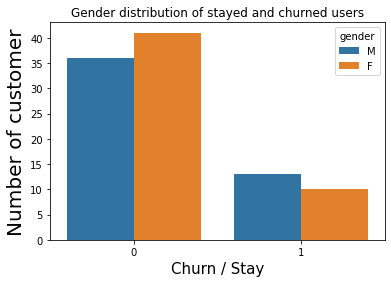

In [11]:
# Plotting a bar plot to show gender distribution between stayed and churned users
gender_pd = df_clean.drop_duplicates(['userId', 'gender']).groupby(['label', 'gender']).count().sort("label").toPandas()

plt.figure()
plt.title('Gender distribution of stayed and churned users')
p = sns.barplot(x = 'label', y = 'count',data = gender_pd, hue = 'gender')
p.set_xlabel("Churn / Stay", fontsize = 15)
p.set_ylabel("Number of customer", fontsize = 20)
plt.show()


In [24]:
# Count the number of users who churned and stayed between different purchase level
# label = 1 means customer churned, label = 0 means customer stayed
# level = 'free' means customer did not purchase the service, level = 'paid' means customers who purchase the service 
df_clean.groupBy("label","level").agg(countDistinct('userId').alias('user_count')).sort("label","level").show()

+-----+-----+----------+
|label|level|user_count|
+-----+-----+----------+
|    0| free|       149|
|    0| paid|       129|
|    1| free|        46|
|    1| paid|        36|
+-----+-----+----------+



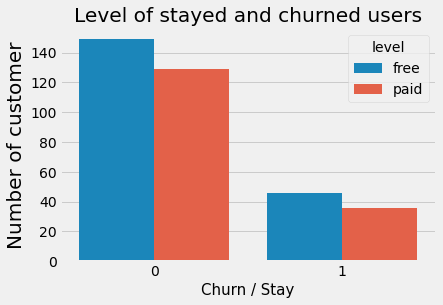

In [ ]:
# Plotting a bar plot to show level distribution between stayed and churned users
level_pd = df_clean.drop_duplicates(['userId', 'level']).groupby(['label', 'level']).count().sort("label").toPandas()

plt.figure()
plt.title('Level of stayed and churned users')
p = sns.barplot(x = 'label', y = 'count',data = level_pd, hue = 'level')
p.set_xlabel("Churn / Stay", fontsize = 15)
p.set_ylabel("Number of customer", fontsize = 20)
plt.show()

In [25]:
# Check the downgrade distribution between churned and stayed customers
# label = 1 means customer churned, label = 0 means customer stayed
df_clean.groupBy("label","downgraded").agg(countDistinct('userId').alias('user_count')).sort("label","downgraded").show()

+-----+----------+----------+
|label|downgraded|user_count|
+-----+----------+----------+
|    0|         0|        54|
|    0|         1|       119|
|    1|         0|        17|
|    1|         1|        35|
+-----+----------+----------+



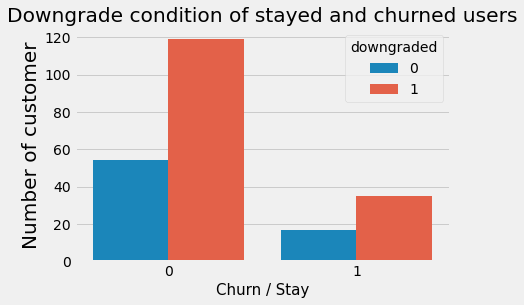

In [ ]:
# Plotting a bar plot to show downgrade condition between stayed and churned users
downgrade_pd = df_clean.drop_duplicates(['userId', 'downgraded']).groupby(['label', 'downgraded']).count().sort("label").toPandas()

plt.figure()
plt.title('Downgrade condition of stayed and churned users')
p = sns.barplot(x = 'label', y = 'count',data = downgrade_pd, hue = 'downgraded')
p.set_xlabel("Churn / Stay", fontsize = 15)
p.set_ylabel("Number of customer", fontsize = 20)
plt.show()

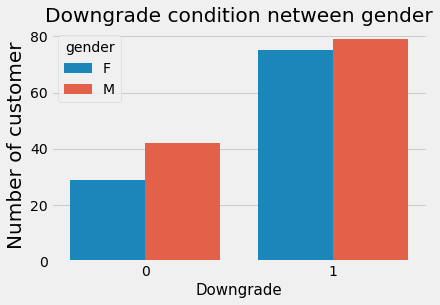

In [ ]:
# Plotting a bar plot to show downgrade condition between gender
# downgrade = 1 means customer downgraded the service, downgrade = 0 means customer doesn't downgraded the service

downgrade_gender = df_clean.drop_duplicates(['userId', 'gender']).groupby(['gender', 'downgraded']).count().sort("gender").toPandas()

plt.figure()
plt.title('Downgrade condition between gender')
p = sns.barplot(x = 'downgraded', y = 'count',data = downgrade_gender, hue = 'gender')
p.set_xlabel("Downgrade", fontsize = 15)
p.set_ylabel("Number of customer", fontsize = 20)
plt.show()

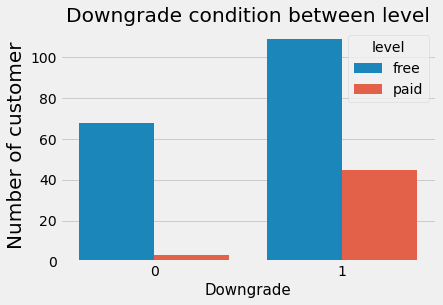

In [ ]:
# Plotting a bar plot to show downgrade condition between gender
# downgrade = 1 means customer downgraded the service, downgrade = 0 means customer doesn't downgraded the service

downgrade_level = df_clean.drop_duplicates(['userId', 'gender']).groupby(['level', 'downgraded']).count().sort("level").toPandas()

plt.figure()
plt.title('Downgrade condition between level')
p = sns.barplot(x = 'downgraded', y = 'count',data = downgrade_level, hue = 'level')
p.set_xlabel("Downgrade", fontsize = 15)
p.set_ylabel("Number of customer", fontsize = 20)
plt.show()

# Feature Engineering

In [26]:
df_clean.columns

['artist',
 'auth',
 'gender',
 'itemInSession',
 'length',
 'level',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userId',
 'state',
 'epoch_time',
 'date',
 'month',
 'agent',
 'label',
 'downgraded']

In [27]:
cancellation_df = df_clean.groupBy('userId').agg(max('ts').alias('lastinteraction'))
df_clean = cancellation_df.join(df_clean, on='userId').withColumn('registered_days', ((col('lastinteraction')-col('registration'))/86400000).cast(IntegerType()))
df_clean = df_clean.drop('lastinteraction','registration')
df_clean.show(2)

+------+-------------+---------+------+-------------+---------+-----+------+--------+---------+--------------------+------+-------------+-----+-------------------+----------+-----+-------+-----+----------+---------------+
|userId|       artist|     auth|gender|itemInSession|   length|level|method|    page|sessionId|                song|status|           ts|state|         epoch_time|      date|month|  agent|label|downgraded|registered_days|
+------+-------------+---------+------+-------------+---------+-----+------+--------+---------+--------------------+------+-------------+-----+-------------------+----------+-----+-------+-----+----------+---------------+
|   100|  Evanescence|Logged In|     M|            0|237.11302| paid|   PUT|NextSong|      256|    Bring Me To Life|   200|1538492662000|   TX|2018-10-02 15:04:22|2018-10-02|   10|Windows|    0|         1|             64|
|   100|Sheena Easton|Logged In|     M|            1|239.62077| paid|   PUT|NextSong|      256|Strut (1993 Digit

In [28]:
level_df = df_clean.orderBy('ts', ascending=False).groupBy('userId').agg(first('level').alias('level_preChurn'))    
df_clean = df_clean.drop('level')
df_clean = df_clean.join(level_df, on='userId')
df_clean.show(2)

+------+-------------+---------+------+-------------+---------+------+--------+---------+--------------------+------+-------------+-----+-------------------+----------+-----+-------+-----+----------+---------------+--------------+
|userId|       artist|     auth|gender|itemInSession|   length|method|    page|sessionId|                song|status|           ts|state|         epoch_time|      date|month|  agent|label|downgraded|registered_days|level_preChurn|
+------+-------------+---------+------+-------------+---------+------+--------+---------+--------------------+------+-------------+-----+-------------------+----------+-----+-------+-----+----------+---------------+--------------+
|   100|  Evanescence|Logged In|     M|            0|237.11302|   PUT|NextSong|      256|    Bring Me To Life|   200|1538492662000|   TX|2018-10-02 15:04:22|2018-10-02|   10|Windows|    0|         1|             64|          paid|
|   100|Sheena Easton|Logged In|     M|            1|239.62077|   PUT|NextSo

In [29]:
temp_daily_song = df_clean.groupBy('userId','date').agg(countDistinct('song').alias('songs')).sort('userId')
daily_song = temp_daily_song.groupBy('userId').avg('songs').withColumnRenamed('avg(songs)', 'avg_daily_song')
df_clean = df_clean.join(daily_song, on='userId')
df_clean = df_clean.drop('song')
df_clean.show(2)

+------+-------------+---------+------+-------------+---------+------+--------+---------+------+-------------+-----+-------------------+----------+-----+-------+-----+----------+---------------+--------------+----------------+
|userId|       artist|     auth|gender|itemInSession|   length|method|    page|sessionId|status|           ts|state|         epoch_time|      date|month|  agent|label|downgraded|registered_days|level_preChurn|  avg_daily_song|
+------+-------------+---------+------+-------------+---------+------+--------+---------+------+-------------+-----+-------------------+----------+-----+-------+-----+----------+---------------+--------------+----------------+
|   100|  Evanescence|Logged In|     M|            0|237.11302|   PUT|NextSong|      256|   200|1538492662000|   TX|2018-10-02 15:04:22|2018-10-02|   10|Windows|    0|         1|             64|          paid|79.9090909090909|
|   100|Sheena Easton|Logged In|     M|            1|239.62077|   PUT|NextSong|      256|   

In [30]:
daily_item_df = df_clean.groupby('userId','date').agg(max('itemInSession')).groupBy('userId').avg('max(itemInSession)').\
                                                            withColumnRenamed('avg(max(itemInSession))', 'avg_daily_items')
df_clean = df_clean.join(daily_item_df, on='userId')
df_clean = df_clean.drop('itemInSession')
df_clean.show(2)

+------+-------------+---------+------+---------+------+--------+---------+------+-------------+-----+-------------------+----------+-----+-------+-----+----------+---------------+--------------+----------------+------------------+
|userId|       artist|     auth|gender|   length|method|    page|sessionId|status|           ts|state|         epoch_time|      date|month|  agent|label|downgraded|registered_days|level_preChurn|  avg_daily_song|   avg_daily_items|
+------+-------------+---------+------+---------+------+--------+---------+------+-------------+-----+-------------------+----------+-----+-------+-----+----------+---------------+--------------+----------------+------------------+
|   100|  Evanescence|Logged In|     M|237.11302|   PUT|NextSong|      256|   200|1538492662000|   TX|2018-10-02 15:04:22|2018-10-02|   10|Windows|    0|         1|             64|          paid|79.9090909090909|118.33333333333333|
|   100|Sheena Easton|Logged In|     M|239.62077|   PUT|NextSong|      2

In [31]:
session_duration = df_clean.groupBy('userId','sessionId').agg(((max('ts')-min('ts'))/86400000).alias('activesession'))
session_duration_df = session_duration.groupBy('userId').avg('activesession').withColumnRenamed('avg(activesession)', 'avg_session')
df_clean = df_clean.join(session_duration_df, on='userId')
df_clean = df_clean.drop('sessionId')
df_clean.show(2)

+------+-------------+---------+------+---------+------+--------+------+-------------+-----+-------------------+----------+-----+-------+-----+----------+---------------+--------------+----------------+------------------+-------------------+
|userId|       artist|     auth|gender|   length|method|    page|status|           ts|state|         epoch_time|      date|month|  agent|label|downgraded|registered_days|level_preChurn|  avg_daily_song|   avg_daily_items|        avg_session|
+------+-------------+---------+------+---------+------+--------+------+-------------+-----+-------------------+----------+-----+-------+-----+----------+---------------+--------------+----------------+------------------+-------------------+
|   100|  Evanescence|Logged In|     M|237.11302|   PUT|NextSong|   200|1538492662000|   TX|2018-10-02 15:04:22|2018-10-02|   10|Windows|    0|         1|             64|          paid|79.9090909090909|118.33333333333333|0.21980489417989418|
|   100|Sheena Easton|Logged In|

In [26]:
df_clean.columns

['userId',
 'artist',
 'auth',
 'gender',
 'length',
 'method',
 'page',
 'status',
 'ts',
 'state',
 'epoch_time',
 'date',
 'month',
 'agent',
 'label',
 'downgraded',
 'registered_days',
 'level_preChurn',
 'avg_daily_song',
 'avg_daily_items',
 'avg_session']

In [55]:
df_model = df_clean.select(['userId','label','downgraded','gender','level_preChurn','agent','state',\
                            'registered_days','avg_daily_items','avg_session','avg_daily_song']).dropDuplicates(['userId'])

df_model.show(n=5)

+------+-----+----------+------+--------------+----------+-----+---------------+------------------+-------------------+-----------------+
|userId|label|downgraded|gender|level_preChurn|     agent|state|registered_days|   avg_daily_items|        avg_session|   avg_daily_song|
+------+-----+----------+------+--------------+----------+-----+---------------+------------------+-------------------+-----------------+
|   100|    0|         1|     M|          paid|   Windows|   TX|             64|118.33333333333333|0.21980489417989418| 79.9090909090909|
|100004|    0|         1|     F|          paid|compatible|   NY|            172| 76.42105263157895|0.12915729717813051|48.89473684210526|
|100005|    1|         0|     M|          free| Macintosh|   LA|             85|              53.5|0.08346296296296296|             38.5|
|100006|    1|         0|     F|          free|   Windows|   MI|              9|              45.0|0.06488425925925925|             26.0|
|100007|    1|         1|     F|  

# Data Transformation

In [56]:
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_model) for column in ['gender','level_preChurn','agent','state'] ]
pipeline = Pipeline(stages=indexers)
df_r = pipeline.fit(df_model).transform(df_model)
df_model = df_r.drop('gender','level_preChurn','agent','state','userId')
df_model.show(1)

+-----+----------+---------------+------------------+-------------------+----------------+------------+--------------------+-----------+-----------+
|label|downgraded|registered_days|   avg_daily_items|        avg_session|  avg_daily_song|gender_index|level_preChurn_index|agent_index|state_index|
+-----+----------+---------------+------------------+-------------------+----------------+------------+--------------------+-----------+-----------+
|    0|         1|             64|118.33333333333333|0.21980489417989418|79.9090909090909|         0.0|                 0.0|        0.0|        1.0|
+-----+----------+---------------+------------------+-------------------+----------------+------------+--------------------+-----------+-----------+
only showing top 1 row



In [58]:
from pyspark.sql.functions import isnan, when, count, col

df_model.select([count(when(isnan(c), c)).alias(c) for c in df_model.columns]).toPandas().unstack()

label                 0    0
downgraded            0    0
registered_days       0    0
avg_daily_items       0    0
avg_session           0    0
avg_daily_song        0    0
gender_index          0    0
level_preChurn_index  0    0
agent_index           0    0
state_index           0    0
dtype: int64

In [57]:
df_model.columns

['label',
 'downgraded',
 'registered_days',
 'avg_daily_items',
 'avg_session',
 'avg_daily_song',
 'gender_index',
 'level_preChurn_index',
 'agent_index',
 'state_index']

In [59]:
feature_columns = [col for col in df_model.columns if col!='label'] 

In [67]:
feature_columns

['downgraded',
 'registered_days',
 'avg_daily_items',
 'avg_session',
 'avg_daily_song',
 'gender_index',
 'level_preChurn_index',
 'agent_index',
 'state_index']

## Check Data Imbalance

In [39]:
m=df_model.groupBy('label').count().orderBy('count').show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



# Modeling

In [60]:
from pyspark.ml.feature import MinMaxScaler

In [64]:
def create_CV_model(classifier,parameters,train):
    '''
    This function will create a cross validation object and return a trained model
    
    Input:
    classifier: a spark ml classification algorithm
    paramaters: parameter list to make grid search
    
    Output:
    fit_model: cross validation fitted model object
    '''
    
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=parameters,
        evaluator = MulticlassClassificationEvaluator(labelCol="label",metricName='f1'),
        numFolds=3)
    fit_model = model.fit(train)
    
    return fit_model

In [65]:
def evaluate_model(model,train,test):
    '''
    This function will evaluate fitted model
    
    Input:
    model: fitted model after applying first function
    train: train data for evaluation 
    test: test data for real validation
    
    Output: a dataframe to show result metrics
    f1train: F1 Score for train data
    f1test: F1 Score for test data
    accuracy_train: Accuracy Score for train data
    accuracy_test: Accuracy Score for test data
    
    '''
    
    pred = model.transform(train)
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
    f1_train = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    accuracy_train = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
    
    pred = model.transform(test)
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
    f1_test = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    accuracy_test = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
    
    df = pd.Series({'F1 Train': f1_train, 
               'Accuracy Train': accuracy_train,
               'F1 Test': f1_test,
               'Accuracy Test' :accuracy_test })
    return df

## Train-Test-Split

In [72]:
train, validation = df_model.randomSplit([0.8, 0.2], seed=42)

## Compute Class Weight

In [75]:
dataset_size = float(train.select('label').count())
numPositives = train.select('label').where('label == 1').count()
numNegatives = float(dataset_size-numPositives)
BalancingRatio= numNegatives/dataset_size
# creating a new column named “classWeights” in the “rest” dataset
train = train.withColumn("classWeights", when(train.label == 1,BalancingRatio).otherwise(1-BalancingRatio))
train.select("classWeights").show(5)

+------------------+
|      classWeights|
+------------------+
|0.2606382978723404|
|0.2606382978723404|
|0.2606382978723404|
|0.2606382978723404|
|0.2606382978723404|
+------------------+
only showing top 5 rows





---



In [45]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


## Logistic Regression

In [76]:
# Train the model and evaluate performance on both train and test set
classifier = LogisticRegression(labelCol="label", featuresCol="scaled_features",weightCol="classWeights",maxIter=10)
paramGrid=ParamGridBuilder().build()

modelLR = create_CV_model(classifier,paramGrid, train)
df_log = evaluate_model(modelLR,train,validation)
df_log

F1 Train          0.711173
Accuracy Train    0.696809
F1 Test           0.749068
Accuracy Test     0.675676
dtype: float64



---



## Random Forest

In [ ]:
# Train the model and evaluate performance
classifier = RandomForestClassifier(labelCol="label", featuresCol="scaled_features",weightCol="classWeights",maxIter=10)
paramGrid=ParamGridBuilder().build()

modelRF = create_CV_model(classifier,paramGrid, train)
df_rf = evaluate_model(modelRF,train,validation)
df_rf

## Feature Importance

In [77]:
modelLR.bestModel.stages[2].coefficients

DenseVector([1.0446, -7.9516, 3.8992, -13.0526, 5.2959, -0.3487, 0.4146, -0.3719, 0.4589])

In [78]:
#Checking features importance
rf_feature_importance_df = pd.DataFrame()
rf_feature_importance_df['feature'] = feature_columns
rf_feature_importance_df['importance'] = modelLR.bestModel.stages[2].coefficients.values.tolist()
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
rf_feature_importance_df

,feature,importance
0,avg_daily_song,5.295949
1,avg_daily_items,3.899159
2,downgraded,1.044590
3,state_index,0.458910
4,level_preChurn_index,0.414646
5,gender_index,-0.348722
6,agent_index,-0.371937
7,registered_days,-7.951639
8,avg_session,-13.052558


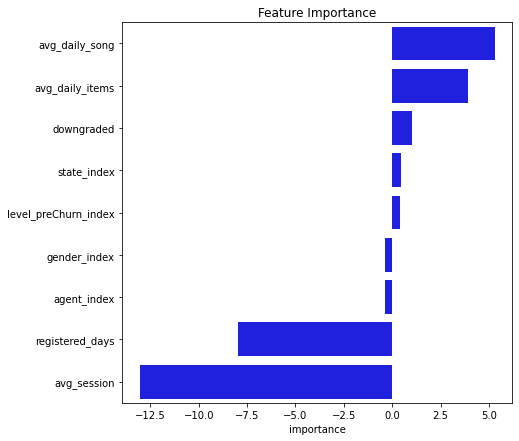

In [79]:
#Let's create a visualization of the feature importance for predicting churn
plt.figure(figsize=(7,7))
sns.barplot(x='importance', y='feature', data=rf_feature_importance_df, color="b")
plt.title('Feature Importance')
plt.ylabel('');



---

